# Computer Vision ECE 5470 Project Report
# Syed Askari Raza

## Introduction

In today’s digital World, there’s an increased need for safety and security of each individual’s data and assets. For this, there are multiple applications allowing verification like fingerprint sensing, biometric sensing, and facial recognition to protect an individual’s owned digital or physical assets since it uniquely gives access to each individual. Therefore, to further explore how facial recognition works, in the application for access control, I undertook the project of Facial Key point Detection. This project is based on Computer Vision techniques and Convolution Neural Networks to predict facial key points on face images data that is unseen.

## Objectives

The primary goal of this project is to get hands on with PyTorch and attempt to implement a project that is very relevant to present requirements in devices and in technology. I pursued this project to explore how efficiently we can predict the Facial features of a face in a given picture since it is of utmost relevance both in access control domain and also in studying the emotions as depicted by the facial expressions which are described by the facial key points. This project also is an opportunity to practice transformations that are commonly used in Image Processing and inspect its effect on the results.

## Tasks

This project was executed on PyTorch, a Python package used for research purposes on Convolutional Neural Networks which is a Neural Network technique used for Image Data. The tasks start off with initially loading a data that readily available on the internet. This is called the YouTube Faces Data which is gathered by performing image processing techniques on YouTube videos of celebrities and then turned it into image frames with annotations on the face as facial key points. It then involved transformation of data to achieve uniformity within all image through resizing, cropping, and normalization. Then using the data, we trained a Convolutional Neural Network model based on customized set up of convolutional layers and their parameters to train the model. We then test it on the test data set of the same data. Finally, we will test it on independent data that is retrieved from different sources to test on completely new data. The tasks are also listed below.

1.	Load the training data from the online available dataset from this link
2.	Visualize the sample training examples to understand the type of data
3.	Since the data is not uniformly sized, we performed rescaling, cropping to maintain the size of all images
4.	We then normalized the data using PyTorch function
5.	We then trained the model on the training data at different parameters
6.	Once we successfully got the right model with desired loss value range, we test it on the test images of the same dataset
7.	Finally, we test it on independent images that do not belong to this dataset




# Methodology

We start off by importing the dataset which is primarily image frames of YouTube videos of celebrities with annotations on the image in the form of purple dots on their facial features. These dots are given by x,y coordinates and as per the specifications of this dataset, there are 68 points marked in each image on the face. The dataset was description can be seen on this link: https://www.cs.tau.ac.il/~wolf/ytfaces/

These keypoints are related to specifications like emotion recognition, face detection.

The program below starts by importing the data and the packages that we'll use in this project. These include:
1. Numpy, Pandas - to represent images as arrays of pixels and process and visualize them
2. Matplotlib - to visualize images
3. OS - to navigate through directory to extract our Python scripts and save the model.
4. CV2 - for image processing and applying CV techniques

## 1. Loading the Data & Keypoints Coordinates

The first step is to load the data which will further be visualized. We start off by importing the data from AWS openly available image data source and unzip the zipped data file.


In [26]:
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2023-12-05 01:51:40--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.81.246, 52.217.47.118, 54.231.230.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.81.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  16.3MB/s    in 22s     

2023-12-05 01:52:03 (14.7 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


Here we simply import all the relevant packages to initially visualize data. We have used all these packages in our Computer Vision course Labs.

In [27]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

We'll take a sample of coordinates of some keypoints on an image from our training data set that we just loaded

In [28]:
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
#key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()

key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


To check the size of our data, we simply inspect the shape of the array to see how many image examples we have. A total of 2462 images are in the training set.

In [29]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


## 2. Visualize Images from Training set with Key points

Here we visualize an image with annotations in the form of key points on them. This gives a perspective of the images set with facial key points that we will train on.

In [30]:
def show_keypoints(image, key_pts):
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


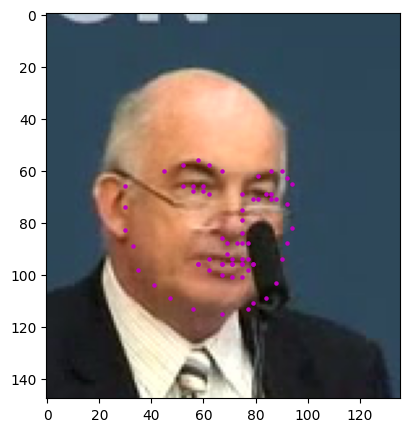

In [31]:

n = 44
image_name = key_pts_frame.iloc[n, 0]
#key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()

key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('/data/training/', image_name)), key_pts)
plt.show()

## 3. Dataset class and Transformations

By using PyTorch tutorials and official guide referenced in Lab 9 of Computer Vision course, we make a dataset class for our keypoints dataset. This class shall also assists me in performing transformations further in the project. The class will change our imported data into a dataset that can be trained.


In [32]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])

        image = mpimg.imread(image_name)

        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]

       # key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts_frame.iloc[idx, 1:].to_numpy()

        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

As we have defined the class, we'll display some images by generating a dataset from the csv file we converted from our zipped dataset.

In [33]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                      root_dir='/data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


0 (219, 195, 3) (68, 2)
1 (240, 256, 3) (68, 2)
2 (305, 239, 3) (68, 2)


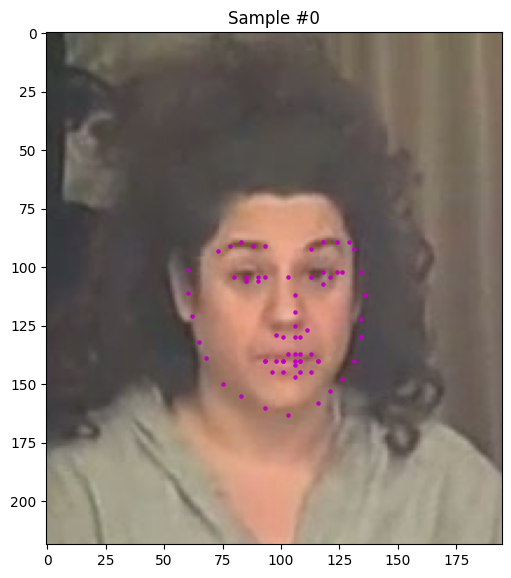

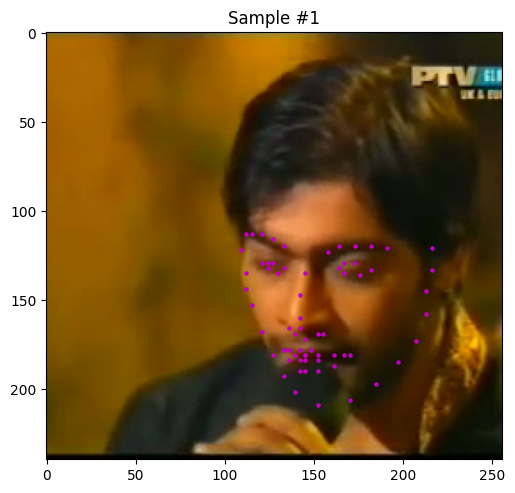

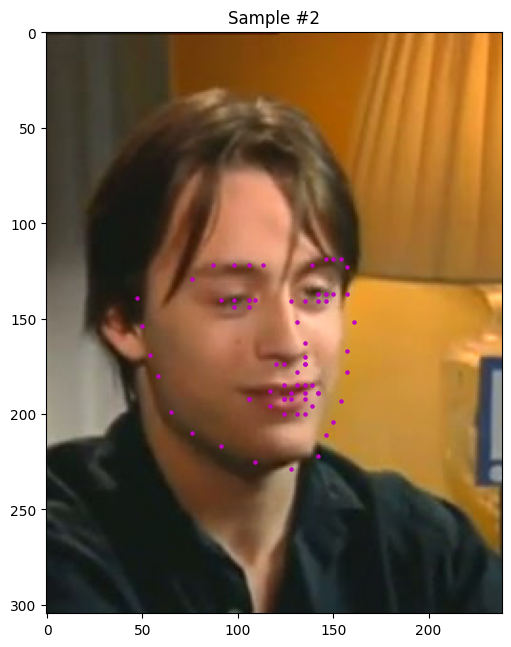

In [34]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):

    # define the size of images
    fig = plt.figure(figsize=(20,10))

    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))

    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])


## 4. Image Transformation

The images are not of the same size and for better training of the CNN, we need to have images that are standard in terms of size and normalized for color ranges.

One very important aspect is to convert the image which is in the form of numpy array to Tensors since Keras, PyTorch use Tensors object type for training.


For this, we created a class that manipulates the images. This class uses CV2 package to perform image manipulation. The first tep we do is to change the image to grayscale and change the colorscale from 0 to 1. Finally, we normalize the keypoints by centering them around 0 by subtracting by mean and dividing by standard deviation to get normalization.

The keypoints and the images both are normalized separately.

At this point, we import discrete transforms class from torchvision which is used mainly for CNN tasks.

Similarly, we created classes to perform rescaling using cv2 and random cropping.

THE KEY COMPUTER VISION TECHNIQUES WE APPLY HERE ARE:
1. Normalization: this is done to convert the images to gray scale and normalize the keypoints to bring them within the range of -1,1
2. Rescaling: Rescale the image in the project before training

Since the data is fed in PyTorch to train as a Tensor, the function also converts the data in tensors.

In [35]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0

        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))

        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))

        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

## 5. Test out the transforms

Here, I applied the transforms we created above to see if they work fine. The images are shown below.

Here we need to test out the transformations with correct parameters. For example, we can't crop an image with a value that is smaller than the actual image size.

Output Discussion:

We can see that if the image is wrongly cropped, the keypoints will reflect wrong segments of the image and the training set will be highly inaccurate. Therefore, we have to maintain uniformity in the cropping of images since the images are of different dimensions.

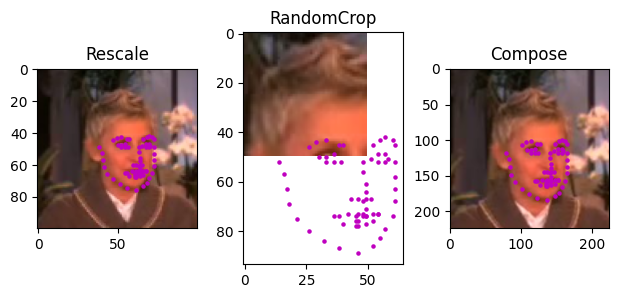

In [36]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 300
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

Discussion:
The images displayed show the effect of rescaling and cropping. We need to ensure that the cropping is done such a way that the facial features are not cropped out like it happened in the image above. This way, the model trains on incorrect pixel intensities and outputs wrong keypoints on the test images.

We now import utilities to ensure our workspaces are active during training of the model.

In [37]:

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 6. Training model

We created a separated pytrhon program that defines the class Net which is used to train the model. Before we import it, the program is as below:

The description of the CNN model we implement is as follows:

Here, the model that we're using is based on three convolutional layers.
Here we created a model in the class defined in standalone Python Program called 'Models'. The model we use is a Convolutional Neural Network that uses 3 convolutional layers.

The first layer is convolved with a kernel_size of 5 for the input images that are single channeled. The output we generate is 32 channel which means we use 32 filters of 5x5 size with a stride of 1 to perform convolution.

In the second layer we take 32 channels as inputs from the previous channel and apply 64 filters of size 3x3x32 to generate a 64 chanelled output. The stride remains 1.

Finally, the third layer uses a kernel of 3x3x64. We are increasing the channels but reducing the height and width dimensions of each channel of the image. The reason behind more filters is to obtain more intricate details of the facial features to better define the placement of keypoints on the facial features on the images.

We then use Maxpooling which basically uses a kernel size of 2 and a stride of 2. We have also added a dilation of 2. This means that the pooling operation will be applied with gaps, effectively skipping elements in the input tensor. The output tensor will have reduced spatial dimensions due to the pooling operation.

We then use dropout which means we turn the neurons or filters to 0 for training to avoid overfitting. This gives a better generalization of the model on unseen test data.
finally we apply a linear layer with a total of 8252 inputs which are flattened from the previous layer output.

In [38]:

import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should choose to initialize the weights of your Net
import torch.nn.init as I


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()


        self.conv1 = nn.Conv2d(1, 32, 5)

        self.conv2 = nn.Conv2d(32, 64, 3)

        self.conv3 = nn.Conv2d(64, 128, 3)

        self.pool = nn.MaxPool2d(2,2)

        self.drop2d = nn.Dropout2d(p=0.2, inplace=False)

        self.drop = nn.Dropout(p=0.2, inplace=False)

        self.fc1 = nn.Linear(128*26*26, 136)



    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.drop(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

In [39]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2d): Dropout2d(p=0.2, inplace=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=86528, out_features=136, bias=True)
)


# 7. Transforming the dataset for training.

Here I transformed the dataset of images and keypoints. The transformation is executed in a separate python progarm and is ecxcuted here. The transformations are as below:

1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

 The python standalone program is as below called data_load python program which has a class FacialKeypointsDataset which extracts the data that we initially imported from AWS datasets. It also defines the functions for image transformation.

In [40]:
#Data_load python program

import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2


class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])

        image = mpimg.imread(image_name)

        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]

        #key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()


        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample



# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0


        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))

        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))

        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [41]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


from data_load import FacialKeypointsDataset

from data_load import Rescale, RandomCrop, Normalize, ToTensor




data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])


assert(data_transform is not None), 'Define a data_transform'


We now transform our dataset by applying the transformations as follows:

1. Rescale to 250x250
2. Crop such that the image is 224x224
3. Normalization

Finally I convert it to tensors for PyTorch to use the right data structure for training.

In [42]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## 8. Batching and Loading the Data

Here, I ave set a batch size of 10 out of over 4000 images set. This is the right proportion to start with since the computation resources are limited in terms of absence of GPU.

In [43]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)


## 9. Testing before Before training the model

Here i simply tested the images on the model that has not yet been trained. The results are as expected really bad. The key points do not match the face at all. I will compare this with the final results.

I have also loaded the dataset here.


In [44]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [45]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

## 10. Apply the model on a test sample

To test the model on a test sample of data, I followed these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [46]:
# test the model on a batch of test images

def net_sample_output():

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)

        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts


In [47]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## 11. Visualize the predicted keypoints

Once I had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.


In [48]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# View Keypoints on untransformed images

The function below was created to take the image batches and predicted key points with groud truth and display as images.

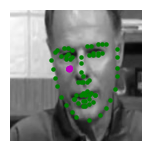

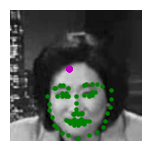

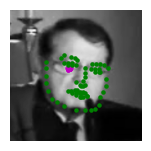

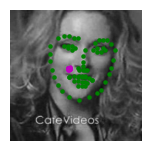

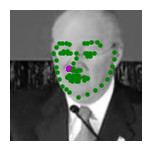

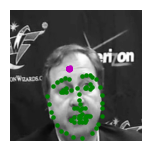

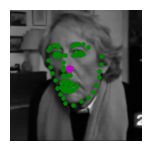

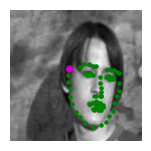

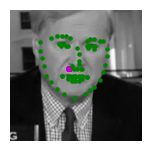

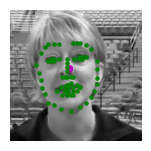

In [49]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts*50.0+100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts*50.0+100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis('off')

    plt.show()

# call it
visualize_output(test_images, test_outputs, gt_pts)

**bold text**## 12. Training

We have created a class in a standalone Python program like we did in lab 2 of Computer Vision Course. This class contains the CNN model that we are going to apply.

Here, the model that we're using is based on three convolutional layers.
Here we created a model in the class defined in standalone Python Program called 'Models'. The model we use is a Convolutional Neural Network that uses 3 convolutional layers.

The first layer is convolved with a kernel_size of 5 for the input images that are single channeled. The output we generate is 32 channel which means we use 32 filters of 5x5 size with a stride of 1 to perform convolution.

In the second layer we take 32 channels as inputs from the previous channel and apply 64 filters of size 3x3x32 to generate a 64 chanelled output. The stride remains 1.

Finally, the third layer uses a kernel of 3x3x64. We are increasing the channels but reducing the height and width dimensions of each channel of the image. The reason behind more filters is to obtain more intricate details of the facial features to better define the placement of keypoints on the facial features on the images.

We then use Maxpooling which basically uses a kernel size of 2 and a stride of 2. We have also added a dilation of 2. This means that the pooling operation will be applied with gaps, effectively skipping elements in the input tensor. The output tensor will have reduced spatial dimensions due to the pooling operation.

We then use dropout which means we turn the neurons or filters to 0 for training to avoid overfitting. This gives a better generalization of the model on unseen test data.
finally we apply a linear layer with a total of 8252 inputs which are flattened from the previous layer output.

## Loss Function

We are going to use a regression loss in this project instead of cross entropy since training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value.


In [50]:
#Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


## Training and its execution

The program below simply executes the training of the model on training dataset

In [51]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


## 13. Batch Size and Epochs

We set batch size of 10 and after multiple iterations, we used 5 epochs only when I got access to Colab GPUs. On CPU the training took substantially long for even 1 epoch.

In [52]:
# train your network
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.15559974163770676
Epoch: 1, Batch: 20, Avg. Loss: 0.0998879823833704
Epoch: 1, Batch: 30, Avg. Loss: 0.09645124413073063
Epoch: 1, Batch: 40, Avg. Loss: 0.08078283481299878
Epoch: 1, Batch: 50, Avg. Loss: 0.08815021626651287
Epoch: 1, Batch: 60, Avg. Loss: 0.0833617027848959
Epoch: 1, Batch: 70, Avg. Loss: 0.08245876096189023
Epoch: 1, Batch: 80, Avg. Loss: 0.11246618181467057
Epoch: 1, Batch: 90, Avg. Loss: 0.07667525336146355
Epoch: 1, Batch: 100, Avg. Loss: 0.09759145975112915
Epoch: 1, Batch: 110, Avg. Loss: 0.09515341706573963
Epoch: 1, Batch: 120, Avg. Loss: 0.07899222560226918
Epoch: 1, Batch: 130, Avg. Loss: 0.0813803106546402
Epoch: 1, Batch: 140, Avg. Loss: 0.09998265951871872
Epoch: 1, Batch: 150, Avg. Loss: 0.09329819567501545
Epoch: 1, Batch: 160, Avg. Loss: 0.0770112231373787
Epoch: 1, Batch: 170, Avg. Loss: 0.08439573384821415
Epoch: 1, Batch: 180, Avg. Loss: 0.0912845827639103
Epoch: 1, Batch: 190, Avg. Loss: 0.12753089405596257
Epoch: 

## 14. Test data

Now, I will show the performane of the model on the test dataset that we previously loaded and converted to tensors. The results are shown below for the predicted vs the ground truth facial keypoints marked on the faces.

In [53]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Results of the model on Test Data set

Here we have visualized some images from the test data set and to compare the predicted keypoints with the true keypoints.

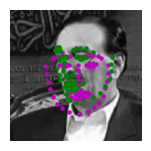

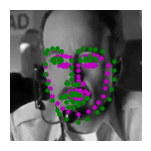

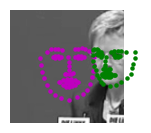

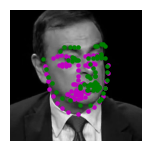

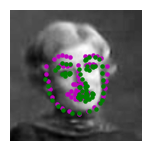

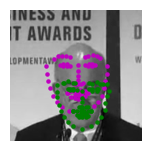

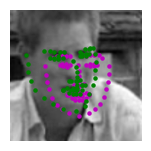

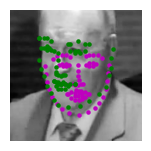

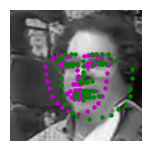

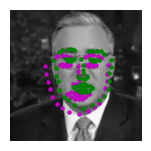

In [54]:
#visualizING test output

visualize_output(test_images, test_outputs, gt_pts)


Here I simply saved the model in my directory

In [55]:
model_name = 'keypoints_model_RG.pt'

# after training, saved my model parameters
torch.save(net.state_dict(), model_name)

## 15. Feature Visualization

Here I extracted a single filter from my first convolutional layer. Its in grayscalle grid. We want to visualize what filters are convolved with the images. Each channel is conolved with a filter which has a specific target to achieve from the spatial patterns.

[[-0.11316667  0.05901043  0.06459889  0.03028295  0.09153267]
 [-0.17570217  0.1590816  -0.09632127  0.13132556  0.15489411]
 [ 0.04300174 -0.00570017 -0.18424891 -0.13565046  0.0857215 ]
 [ 0.10661493  0.15387483 -0.02937688  0.17278284 -0.16287693]
 [-0.08857308  0.08667422  0.06126913  0.13169648 -0.10188922]]
(5, 5)


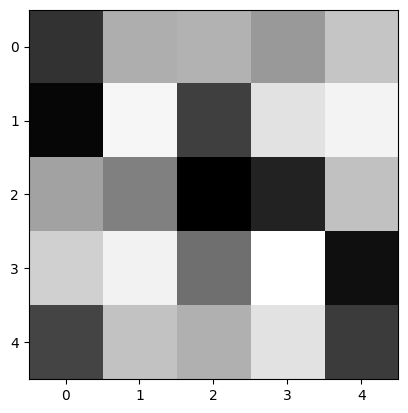

In [56]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## 16. Last Section - Testing on my own data (not from Test dataset)

Now that I hae trained the neural network to detect facial keypoints, I will evaluate its performance on images that in the test set. Also, I will test it on my own images from the gallery.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).

2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that the model expects.

3. Use the trained model to detect facial keypoints on the image.


## Testing the Results on our dataset

I selected a couple of images from an event in my family. We'll see how the model Net() is trained and the results on these images from a completely different distribution. These images have noisy backgrounds and multiple faces for better evaluation of the model.

Step 1: I have imported the images as jpegs  

Step 2: Detect faces with Haar cascade classifier

Step 3: Create a bounding box around the face

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2d): Dropout2d(p=0.2, inplace=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=86528, out_features=136, bias=True)
)

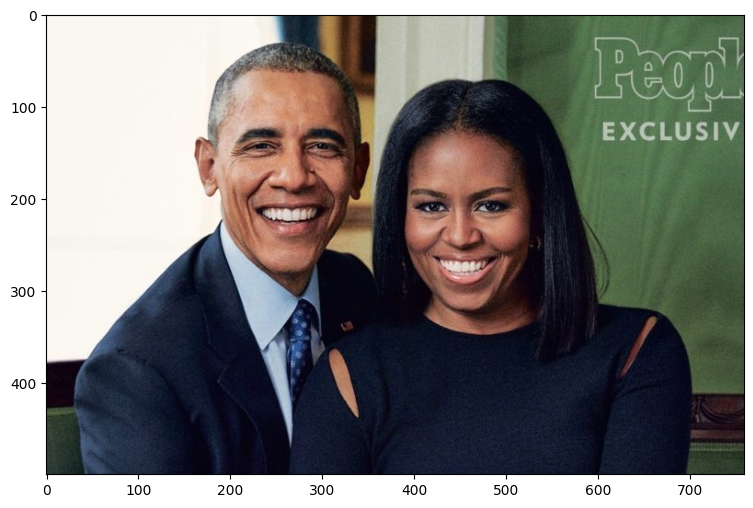

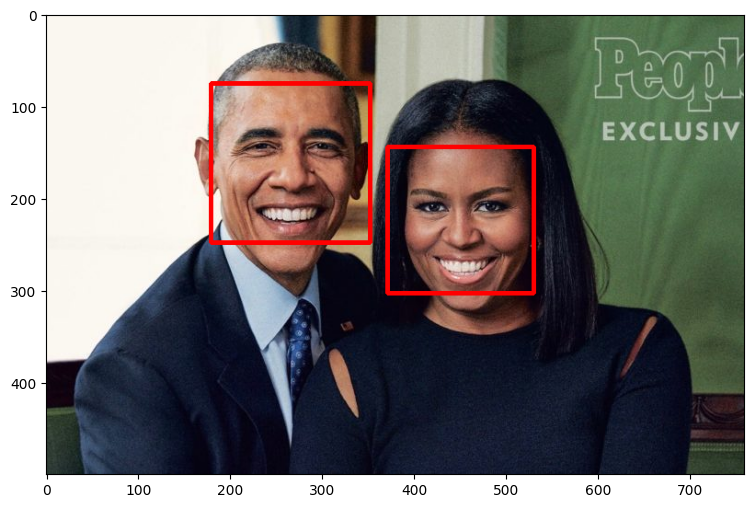

In [66]:
import cv2
# load in color image for face detection
image = cv2.imread('obamas.jpg')

# switch red and blue color channels
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)


# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)


import torch
from models import Net

net = Net()

net.load_state_dict(torch.load('keypoints_model_RG.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

## Loading the saved Model and Testing on our sample images

Using images from a personal event of my family, I tested the model with the results below:

The working is as follows:

1. I'm looping over each detected face in the image
2. The faces will be transformed into tensors that the CNN accepts for which we also have to use the *squeeze* function.
3. Transform the face region by changing into grayscale, rescaling, and reshaping the detected face to 224x224 for the CNN to accept it



The sizes of faces detected by a Haar detector and the faces my network has been trained on are of different sizes. We added padding since the model generated keypoints that were too small for the given face.





The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected roi before giving it as input to your model.




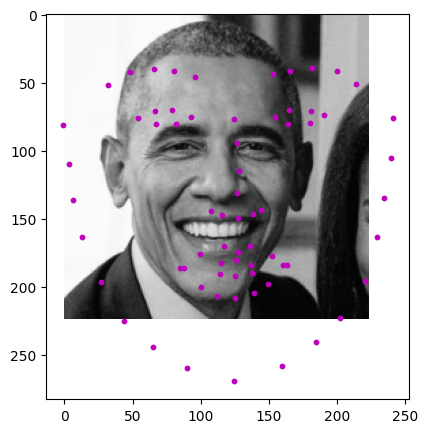

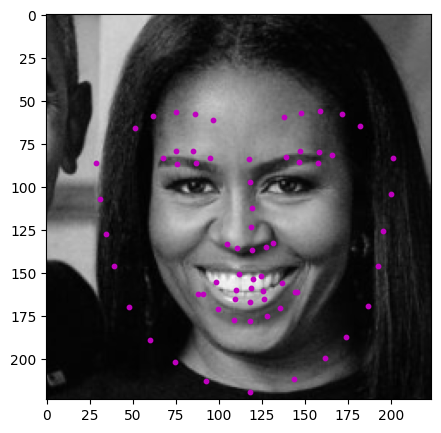

In [67]:
def show_all_keypoints(image, keypoints):
    """
    Visuzlizing the image and the keypoints on it.
    """
    plt.figure(figsize=(5,5))

    keypoints = keypoints.data.numpy()
    keypoints = keypoints * 55.0 + 95 # adjust keypoint size.
    keypoints = np.reshape(keypoints, (68, -1)) # reshape for proper display on the face

    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))  # convert to numpy image shape (H x W x C)
    image = np.squeeze(image)
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=40, marker='.', c='m')

image_copy = np.copy(image)

# loop over the detected faces from haar cascade
for (x,y,w,h) in faces:

    # Select the region of interest that is the face in the image
    roi = image_copy[y-50:y+h+50, x-50:x+w+50]

    #Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    #Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255

    #Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))

    #Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = np.reshape(roi, (1, 1, 224, 224))
    roi_tensor = torch.from_numpy(roi)
    roi_tensor = roi_tensor.type(torch.FloatTensor)

    #Make facial keypoint predictions using your loaded, trained network
    keypoints = net(roi_tensor)

    #Display each detected face and the corresponding keypoints
    show_all_keypoints(roi_tensor.squeeze(0), keypoints)


## Discussion on the Project:

## Model and Loss Function Selection:

The combination of Smooth L1 loss and the Adam optimizer is well-suited for keypoint detection tasks:

Smooth L1 loss is robust to outliers and helps in handling noisy keypoints annotations.

Adam optimizer adjusts learning rates adaptively, leading to faster convergence and better handling of complex loss landscapes.


## Model:

My original architecture consisted of two blocks of two convolutional layers, an interstitial layer of maximum pooling, and an output layer of maximum pooling and fully convolutional layers. Because the model was too big for this workspace, I switched to a more straightforward model that alternates convolutional and max pooling layers, with a smaller fully connected layer at the end. Both 2D dropout and regular dropout were included prior to the completely conected layer, following the first convolutional layer.


## Parameters for the model:

I tried training the model with higher number of epochs but the workspace was not allowing giving error that data loader is killed. I was also training on the CPU. Therefore, I tried with a maximum of 2 epochs before it stopped working.

However, as I have used Google Colab to perform Labs of this course, which provided me with GPUs. Therefore, I iterated and achieved better performance and lower loss with 5 epochs. Increasing the batch size was also giving similar memory overflow issue so I decided to stick with the provided value of 10.

Most mportant results seemed to be decent with this values.

## Conclusion:

This project is highly dependent on the type of normalization we perform on our images since each image is of different size and parameters. Therefore, one challenge in this project was to understand the required normalization and the program to execute it. Moreover, the because of computation limits, the training process had to be limited. Therefore, the maximum computation I could perform was on 5 epochs at a batch size of 10 given the amount of data set. The results
